In [1]:
import pandas

users = pandas.read_csv('dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pandas.read_csv('dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pandas.read_csv('dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pandas.read_csv('dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

movies_train.head()

,title,genre
movieid,,
1650,Washington Square (1997),[Drama]
185,"Net, The (1995)","[Sci-Fi, Thriller]"
1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3204,"Boys from Brazil, The (1978)",[Thriller]
1901,Dear Jesse (1997),[Documentary]


In [2]:
import os

folder_img_path = 'dataset/ml1m-images'
movies_train['id'] = movies_train.index
movies_train.reset_index(inplace=True)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)

movies_test['id'] = movies_test.index
movies_test.reset_index(inplace=True)
movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)

movies_train.head()

,movieid,title,genre,id,img_path
0,1650,Washington Square (1997),[Drama],1650,dataset/ml1m-images\1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185,dataset/ml1m-images\185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377,dataset/ml1m-images\1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204,dataset/ml1m-images\3204.jpg
4,1901,Dear Jesse (1997),[Documentary],1901,dataset/ml1m-images\1901.jpg


In [1]:
from gradio_client import Client

title = "Washington Square (1997)"
client = Client("https://osanseviero-mistral-super-fast.hf.space/")
client.predict("Washington Square (1997)", 0.9, 256, 0.9, 1.2, api_name="/chat")

Loaded as API: https://osanseviero-mistral-super-fast.hf.space/ ✔


' "Washington Square" is a 20th-century American play by Arthur Miller. It tells the story of Bill Calhoun, a struggling writer who falls in love with Sally Hayes, a young woman from an upper-class family. The play explores themes such as class, ambition, and social status in 1840s New York City.\n\nThe play was first produced on Broadway in 1956, starring Lauren Bacall as Sally Hayes and Montgomery Clift as Bill Calhoun. In recent years, it has been revived several times, including a successful production at the Roundabout Theatre Company in 2013.</s>'

In [6]:
from gradio_client import Client
from tqdm import tqdm
import numpy as np

client = Client("https://osanseviero-mistral-super-fast.hf.space/")

def get_summary(title):
    global client
    try:
        return client.predict(title, 0.9, 256, 0.9, 1.2, api_name="/chat")
    except:
        try:
            client = Client("https://osanseviero-mistral-super-fast.hf.space/")
            return client.predict(title, 0.9, 256, 0.9, 1.2, api_name="/chat")
        except:
            print(f'Error with {title}')
            return None
        
tqdm.pandas()

movies_train['summary'] = movies_train.title.progress_apply(get_summary)
movies_train.to_csv('dataset/movies_train.csv', index=False)

movies_test['summary'] = movies_test.title.progress_apply(get_summary)    
movies_test.to_csv('dataset/movies_test.csv', index=False)

In [3]:
import pandas as pd

movies_train = pd.read_csv('dataset/movies_train.csv')
movies_test = pd.read_csv('dataset/movies_test.csv')

movies_train.head()

,movieid,title,genre,id,img_path,summary
0,1650,Washington Square (1997),['Drama'],1650,dataset/ml1m-images\1650.jpg,"""Washington Square"" is a 20th-century America..."
1,185,"Net, The (1995)","['Sci-Fi', 'Thriller']",185,dataset/ml1m-images\185.jpg,"""Net"" is a 20th-century American play by Paul..."
2,1377,Batman Returns (1992),"['Action', 'Adventure', 'Comedy', 'Crime']",1377,dataset/ml1m-images\1377.jpg,"""Batman Returns"" is a superhero film directed..."
3,3204,"Boys from Brazil, The (1978)",['Thriller'],3204,dataset/ml1m-images\3204.jpg,"""Boys from Brazil"" is a horror thriller film..."
4,1901,Dear Jesse (1997),['Documentary'],1901,dataset/ml1m-images\1901.jpg,"""Dear Jesse"" is an American comedy drama fil..."


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("nickmuchi/distilroberta-base-movie-genre-prediction")
model = AutoModelForSequenceClassification.from_pretrained("nickmuchi/distilroberta-base-movie-genre-prediction")
pipeline = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
# pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer, top_k=None)

res = pipeline("Batman Returns (1992)")
res

[[1.3873525857925415,
  1.1331429481506348,
  -0.8626436591148376,
  -0.5688660740852356,
  0.8573216199874878,
  -0.41734230518341064,
  -0.9447510838508606,
  -1.7857648134231567,
  2.031477928161621,
  -0.6985796689987183]]

In [5]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image

vgg19 = VGG19(weights='imagenet')
img = image.load_img('dataset/ml1m-images/1.jpg', target_size=(224, 224))
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

y_hat = vgg19.predict(img)
y_hat.shape

1/1 [==============================] - 1s 1s/step


(1, 1000)

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm import tqdm

class ImdbDataset(Dataset):
    def __init__(self, is_train=True):
        if is_train:
            self.data =  movies_train
        else:
            self.data = movies_test

        self.title_vector = np.zeros((self.data.shape[0], 10))
        self.img_vector = np.zeros((self.data.shape[0], 1000))
        
        for index, row in self.data.iterrows():
            self.title_vector[index] = np.array(pipeline(row.title)[0])

            img_path = row.img_path
            if os.path.exists(img_path):
                img = image.load_img(img_path, target_size=(224, 224))
                img = image.img_to_array(img)
            else:
                img = np.random.rand(224,224,3)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
            img_vector = vgg19.predict(img)
            self.img_vector[index] = img_vector.reshape(-1)

        # label genre
        with open('dataset/genres.txt', 'r') as f:
            genre_all = f.readlines()
            genre_all = [x.replace('\n','') for x in genre_all]
        self.genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}

    def __getitem__(self, index):
        genre = self.data.iloc[index].genre

        # preprocess text
        title_vec = self.title_vector[index]
        title_tensor = torch.from_numpy(title_vec).float()

        # preprocess image
        img_vec = self.img_vector[index]
        img_tensor = torch.from_numpy(img_vec).float()        

        # preprocess label
        genre_vector = np.zeros(len(self.genre2idx))

        for g in genre:
            genre_vector[self.genre2idx[g]] = 1
        genre_tensor = torch.from_numpy(genre_vector).float()

        return title_tensor, img_tensor, genre_tensor

    def __len__(self):
        return len(self.data)

In [ ]:
train_set = ImdbDataset(is_train=True)
test_set = ImdbDataset(is_train=False)

# save dataset
torch.save(train_set, 'dataset/train_set_vgg19_hf.pt')
torch.save(test_set, 'dataset/test_set_vgg19_hf.pt')

In [5]:
import torch
from torch.utils.data import DataLoader

# load dataset
train_data = torch.load('dataset/train_set_vgg19_hf.pt')
test_data = torch.load('dataset/test_set_vgg19_hf.pt')

# create dataloader
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)

(98, 25)

In [6]:
for title, img, genre in train_loader:
    print(title.shape, img.shape, genre.shape)
    break
for title, img, genre in test_loader:
    print(title.shape, img.shape, genre.shape)
    break

torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])
torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])


In [7]:
from torch import nn

class ImdbModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1010, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 18),
        )
        self.norm_img = nn.BatchNorm1d(1000)
        self.norm_title = nn.BatchNorm1d(10)


    def forward(self, title, img):
        # normalize
        title = self.norm_title(title)
        img = self.norm_img(img)

        x = torch.cat([title, img], dim=1)
        x = self.fc(x)
        return x
    
model = ImdbModel_2()
model

ImdbModel_2(
  (fc): Sequential(
    (0): Linear(in_features=1010, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=18, bias=True)
  )
  (norm_img): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm_title): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [10]:
from tqdm import tqdm
from torchmetrics.classification import MultilabelF1Score, MultilabelPrecision, MultilabelRecall

num_labels = genre.shape[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

history = {'train_loss': [], 'test_loss': []}
f1_score = {'train': [], 'test': []}

f1 = MultilabelF1Score(num_labels=num_labels, threshold=0.5, average='macro')
f1 = f1.to(device)
precision = MultilabelPrecision(num_labels=num_labels, threshold=0.5, average='macro')
precision = precision.to(device)
recall = MultilabelRecall(num_labels=num_labels, threshold=0.5, average='macro')
recall = recall.to(device)
 
def test(model):
    model.eval()
    test_loss = 0
    f1_all = 0
    precision_all = 0
    recall_all = 0

    with torch.no_grad():
        for title, img, genre in test_loader:
            title, img, genre = title.to(device), img.to(device), genre.to(device)
            outputs = model(title, img)
            loss = criterion(outputs, genre)
            test_loss += loss.item()
            
            f1_all += f1(outputs, genre)
            precision_all += precision(outputs, genre)
            recall_all += recall(outputs, genre)

    test_loss /= len(test_loader)
    f1_all /= len(test_loader)
    precision_all /= len(test_loader)
    recall_all /= len(test_loader)

    return test_loss, f1_all, precision_all, recall_all

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for idx, (title, img, genre) in enumerate(tqdm(train_loader)):
        title, img, genre = title.to(device), img.to(device), genre.to(device)
        optimizer.zero_grad()
        outputs = model(title, img)
        loss = criterion(outputs, genre)
        loss.backward()
        optimizer.step()

    train_loss = loss.item()
    test_loss, f1_all, precision_all, recall_all = test(model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, f1: {f1_all:.4f}, precision: {precision_all:.4f}, recall: {recall_all:.4f}')

100%|██████████| 98/98 [00:02<00:00, 39.00it/s]


Epoch 1/20, train_loss: 4.6350, test_loss: 7.8505, f1: 0.2015, precision: 0.1526, recall: 0.4188


100%|██████████| 98/98 [00:03<00:00, 27.37it/s]


Epoch 2/20, train_loss: 5.2820, test_loss: 7.2465, f1: 0.2013, precision: 0.1470, recall: 0.4000


100%|██████████| 98/98 [00:02<00:00, 42.19it/s]


Epoch 3/20, train_loss: 6.0148, test_loss: 8.0157, f1: 0.2075, precision: 0.1546, recall: 0.4169


100%|██████████| 98/98 [00:02<00:00, 40.86it/s]


Epoch 4/20, train_loss: 1.4933, test_loss: 7.9835, f1: 0.2139, precision: 0.1589, recall: 0.4281


100%|██████████| 98/98 [00:02<00:00, 35.17it/s]


Epoch 5/20, train_loss: 3.8537, test_loss: 7.7987, f1: 0.2077, precision: 0.1563, recall: 0.4090


100%|██████████| 98/98 [00:08<00:00, 10.95it/s]


Epoch 6/20, train_loss: 0.7437, test_loss: 8.2086, f1: 0.2136, precision: 0.1608, recall: 0.4201


100%|██████████| 98/98 [00:08<00:00, 11.54it/s]


Epoch 7/20, train_loss: 2.8073, test_loss: 8.5922, f1: 0.2165, precision: 0.1641, recall: 0.4021


100%|██████████| 98/98 [00:04<00:00, 20.94it/s]


Epoch 8/20, train_loss: 5.6153, test_loss: 8.5953, f1: 0.2175, precision: 0.1602, recall: 0.4297


100%|██████████| 98/98 [00:04<00:00, 22.54it/s]


Epoch 9/20, train_loss: 1.6342, test_loss: 8.2093, f1: 0.2162, precision: 0.1590, recall: 0.4319


100%|██████████| 98/98 [00:07<00:00, 12.80it/s]


Epoch 10/20, train_loss: 4.8747, test_loss: 8.2506, f1: 0.2037, precision: 0.1531, recall: 0.3866


100%|██████████| 98/98 [00:04<00:00, 24.32it/s]


Epoch 11/20, train_loss: 5.0010, test_loss: 10.4845, f1: 0.2048, precision: 0.1527, recall: 0.4077


100%|██████████| 98/98 [00:03<00:00, 26.45it/s]


Epoch 12/20, train_loss: 2.4630, test_loss: 8.9631, f1: 0.1995, precision: 0.1484, recall: 0.4041


100%|██████████| 98/98 [00:01<00:00, 49.01it/s]


Epoch 13/20, train_loss: 1.3180, test_loss: 8.2508, f1: 0.2082, precision: 0.1527, recall: 0.4208


100%|██████████| 98/98 [00:02<00:00, 48.43it/s]


Epoch 14/20, train_loss: 4.4633, test_loss: 8.5410, f1: 0.1989, precision: 0.1474, recall: 0.3975


100%|██████████| 98/98 [00:02<00:00, 33.95it/s]


Epoch 15/20, train_loss: 2.8416, test_loss: 9.2674, f1: 0.2089, precision: 0.1558, recall: 0.3989


100%|██████████| 98/98 [00:01<00:00, 54.69it/s]


Epoch 16/20, train_loss: 3.5779, test_loss: 8.3983, f1: 0.2052, precision: 0.1545, recall: 0.3942


100%|██████████| 98/98 [00:02<00:00, 38.39it/s]


Epoch 17/20, train_loss: 9.9172, test_loss: 7.9981, f1: 0.2067, precision: 0.1518, recall: 0.4065


100%|██████████| 98/98 [00:02<00:00, 43.96it/s]


Epoch 18/20, train_loss: 2.2771, test_loss: 9.4998, f1: 0.2081, precision: 0.1577, recall: 0.3865


100%|██████████| 98/98 [00:02<00:00, 43.32it/s]


Epoch 19/20, train_loss: 2.2126, test_loss: 8.6640, f1: 0.1992, precision: 0.1485, recall: 0.3906


100%|██████████| 98/98 [00:02<00:00, 37.11it/s]


Epoch 20/20, train_loss: 1.5668, test_loss: 7.8617, f1: 0.2186, precision: 0.1632, recall: 0.4187


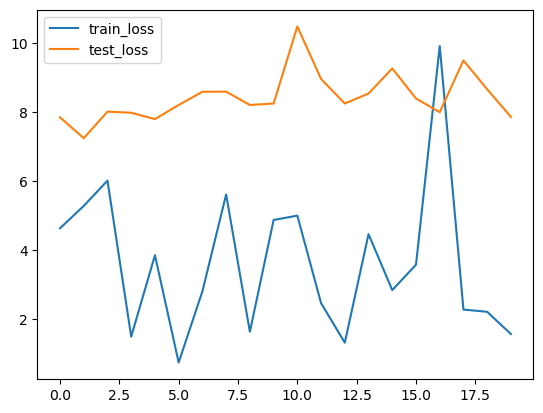

In [11]:
from matplotlib import pyplot as plt
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.legend()
plt.show()